# Report

In [1]:
library(ggplot2)
library(dplyr)
library(terra)
library(sf)
library(scales)
library(patchwork)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 


terra 1.8.29


Warning message:
package ‘terra’ was built under R version 4.3.3 


Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE

Attaching package: ‘scales’

The following object is masked from ‘package:terra’:

    rescale


Attaching package: ‘patchwork’

The following object is masked from ‘package:terra’:

    area



# Data

In [2]:
cleaning_data = read.csv("Data/Records/cleaning_data.csv")
insects_records <- read.csv("Data/Records/insects_records_clean.csv")

ecu <- st_read("Data/Shp/ecuador_limits.shp", quiet = TRUE)
snap <- st_read("Data/Shp/snap.shp", quiet = TRUE)
natural_regions <- st_read("Data/Shp/ron_2011_no_UTM.shp", quiet = TRUE)

# =========================
# 3) Asegurar CRS = 4326 y geometrías válidas
# =========================
to_4326_valid <- function(x){
  x <- st_make_valid(x)
  if (is.na(st_crs(x))) st_crs(x) <- 4326
  st_transform(x, 4326)
}

ecu <- to_4326_valid(ecu)
snap <- to_4326_valid(snap)
natural_regions <- to_4326_valid(natural_regions)

# =========================
# 4) Convertir registros a puntos sf (4326)
# =========================
stopifnot(all(c("decimalLongitude","decimalLatitude") %in% names(insects_records)))

insects_pts <- st_as_sf(
  insects_records,
  coords = c("decimalLongitude", "decimalLatitude"),
  crs = 4326,
  remove = FALSE
) %>%
  st_make_valid()

# =========================
# 5) Cortar (clip) capas a Ecuador
#    - Puntos: quedarse solo con puntos dentro de Ecuador
#    - Polígonos: recortar a Ecuador
# =========================
ecu_u <- st_union(ecu)


# Results

## Report data cleaning

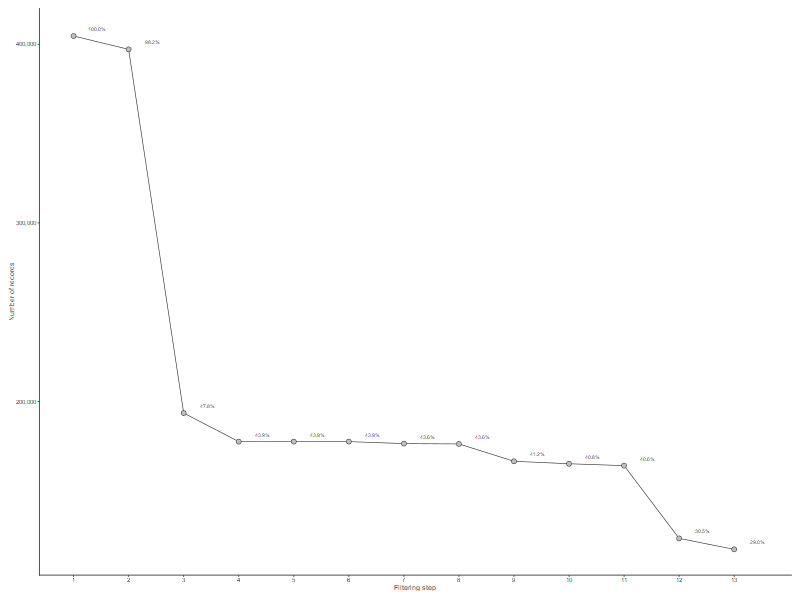

In [3]:
# % retained (optional label)
retained_pct <- 100 * cleaning_data$len_data[nrow(library(scales))] / cleaning_data$len_data[1]

cleaning_data <- cleaning_data %>%
  arrange(steps) %>%
  mutate(
    retained_pct = 100 * len_data / first(len_data),
    decreased_pct = 100 - retained_pct,
    removed_abs = lag(len_data) - len_data,
    removed_pct_prev = 100 * (lag(len_data) - len_data) / lag(len_data)
  )

retained_final  <- cleaning_data$retained_pct[nrow(cleaning_data)]
decreased_final <- cleaning_data$decreased_pct[nrow(cleaning_data)]

filtering_plot <- ggplot(cleaning_data, aes(x = steps, y = len_data)) +
  geom_line(color = "grey20", linewidth = 0.3) +
  geom_point(color = "grey20", fill = "grey75", shape = 21, size = 2.1, stroke = 0.4) +
  geom_text(aes(label = sprintf("%.1f%%", retained_pct), nudge_x = 0.42 ,   nudge_y = 1000),
                vjust = -0.8, size = 1.6, color = "grey20")+
  scale_x_continuous(breaks = cleaning_data$steps) +
  scale_y_continuous(labels = label_comma(accuracy = 1)) +
  labs(x = "Filtering step", y = "Number of records") +
  # Etiqueta final: retenido y disminución acumulada vs inicial

  theme_classic(base_size = 7) +
  theme(
    axis.text = element_text(color = "grey20"),
    axis.title = element_text(color = "grey20"),
    axis.line = element_line(color = "grey20", linewidth = 0.4),
    axis.ticks = element_line(color = "grey20", linewidth = 0.4),
    plot.margin = margin(3, 3, 3, 3, "mm")
  )

filtering_plot

In [4]:
# Single-column width: ~85 mm (common journal 1-column). Height ajustable.
ggsave(
  filename = "Results/Reports/Plots/records_filtering_steps_single_column.png",
  plot = filtering_plot,
  width = 85, height = 70, units = "mm", dpi = 600, bg = "white"
)

## Distribution per taxonomical data

In [5]:
# Puntos dentro de Ecuador
in_ecu <- lengths(st_within(insects_pts, ecu_u)) > 0
insects_pts_ecu <- insects_pts[in_ecu, ]

# Species 

sp_n = length (unique(insects_pts_ecu$scientificName))
genus_n = length(unique(insects_pts_ecu$genus))
families_n = length (unique(insects_pts_ecu$family))

cat("sp: ",sp_n, "genus: ",genus_n, "families: ",families_n)

sp:  8626 genus:  3303 families:  317

## Distribution per order

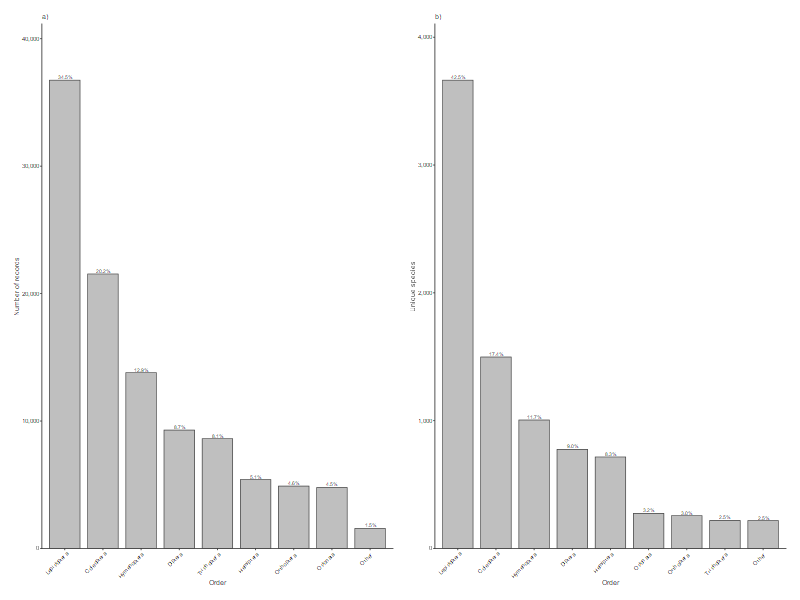

In [6]:

# -------------------------
# Registros: top 8 + Otro
# -------------------------
ord_rec_raw <- insects_pts_ecu |>
  count(order, name = "n_records") |>
  arrange(desc(n_records))

top8_rec <- ord_rec_raw |> slice_head(n = 8) |> pull(order)

ord_rec <- ord_rec_raw |>
  mutate(order_grp = if_else(order %in% top8_rec, order, "Other")) |>
  group_by(order_grp) |>
  summarise(n_records = sum(n_records), .groups = "drop") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(order_grp = factor(order_grp, levels = c(top8_rec, "Other")[c(top8_rec, "Other") %in% order_grp]))

# -------------------------
# Especies únicas: top 8 + Otro
# -------------------------
ord_sp_raw <- insects_pts_ecu |>
  distinct(order, scientificName) |>
  count(order, name = "n_species") |>
  arrange(desc(n_species))

top8_sp <- ord_sp_raw |> slice_head(n = 8) |> pull(order)

ord_sp <- ord_sp_raw |>
  mutate(order_grp = if_else(order %in% top8_sp, order, "Other")) |>
  group_by(order_grp) |>
  summarise(n_species = sum(n_species), .groups = "drop") |>
  mutate(pct_species = 100 * n_species / sum(n_species)) |>
  arrange(desc(n_species)) |>
  mutate(order_grp = factor(order_grp, levels = c(top8_sp, "Other")[c(top8_sp, "Other") %in% order_grp]))

# ============================================================
# Estilo (idéntico a los gráficos anteriores)
# ============================================================
base_theme <- theme_classic(base_size = 7) +
  theme(
    axis.text  = element_text(color = "grey20"),
    axis.title = element_text(color = "grey20"),
    axis.line  = element_line(color = "grey20", linewidth = 0.4),
    axis.ticks = element_line(color = "grey20", linewidth = 0.4),
    plot.margin = margin(3, 3, 3, 3, "mm"),
    plot.title = element_text(color = "grey20", size = 7, hjust = 0)
  )

# a) Registros
reg_order<- ggplot(ord_rec, aes(x = order_grp, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "a)",
    x = "Order",
    y = "Number of records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

# b) Especies
sp_order <- ggplot(ord_sp, aes(x = order_grp, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "b)",
    x = "Order",
    y = "Unique species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

(reg_order | sp_order) + plot_layout(widths = c(1, 1))


## Distribution per Database

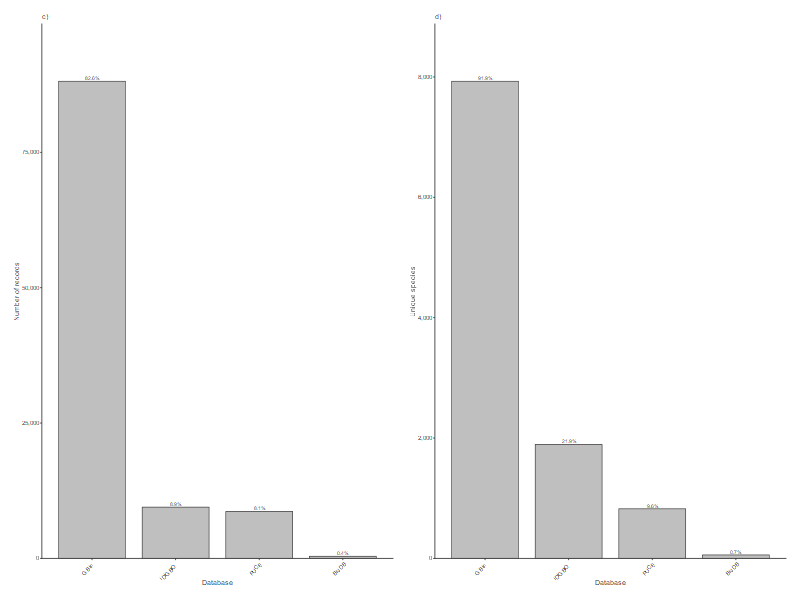

In [7]:
db_rec <- insects_pts_ecu |>
  count(database_name, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(database_name = factor(database_name, levels = database_name))

# -------------------------
# Especies únicas por base de datos
# Barra: n_species = especies únicas dentro del grupo (igual que antes)
# Porcentaje: respecto a riqueza global (S_global) del dataset
# -------------------------
S_global <- insects_pts_ecu |>
  distinct(scientificName) |>
  nrow()

db_sp <- insects_pts_ecu |>
  distinct(database_name, scientificName) |>
  count(database_name, name = "n_species") |>
  mutate(
    pct_species = 100 * n_species / S_global  # <-- cambio clave
  ) |>
  arrange(desc(n_species)) |>
  mutate(database_name = factor(database_name, levels = database_name))



# c) Registros por database_name
reg_database <- ggplot(db_rec, aes(x = database_name, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "c)",
    x = "Database",
    y = "Number of records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

# d) Especies únicas por database_name
sp_database <- ggplot(db_sp, aes(x = database_name, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "d)",
    x = "Database",
    y = "Unique species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

(reg_database | sp_database) + plot_layout(widths = c(1, 1))


## Dsitribution per Institution code

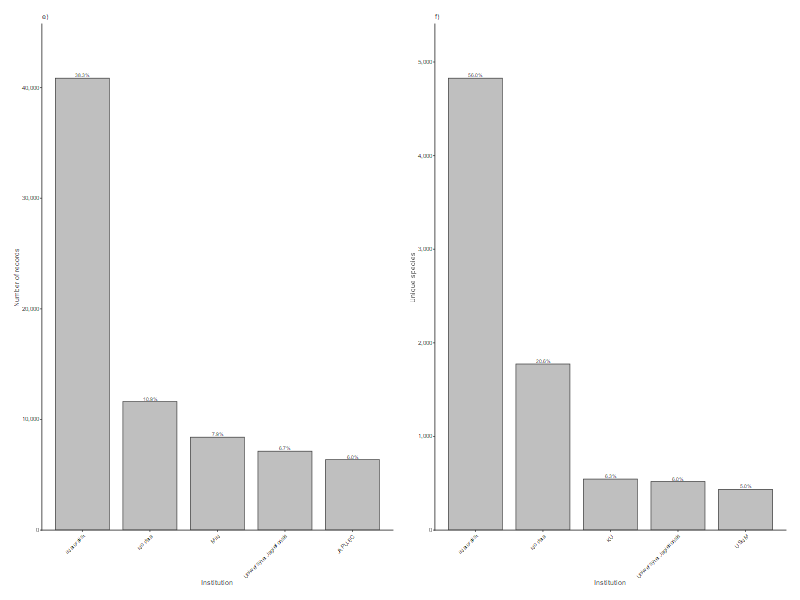

In [9]:


df <- insects_pts_ecu |>
  st_drop_geometry() |>
  mutate(
    institutionCode = if_else(is.na(institutionCode) | institutionCode == "", "No data", institutionCode),
    institutionCode = if_else(institutionCode == "Uniwersytet Jagiello?ski", "Uniwersytet Jagielloński", institutionCode)
  ) |>
  filter(!is.na(scientificName), scientificName != "")

# ============================================================
# 1) REGISTROS: calcular para todas, graficar top 5
#    pct_records = % del total de registros del dataset
# ============================================================
inst_rec_all <- df |>
  count(institutionCode, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records))

inst_rec_top5 <- inst_rec_all |>
  slice_head(n = 5) |>
  mutate(institutionCode = factor(institutionCode, levels = institutionCode))

# ============================================================
# 2) ESPECIES: calcular para todas, graficar top 5
#    Barra: n_species (especies únicas dentro del grupo)
#    pct_species = % de la riqueza global del dataset (S_global)
# ============================================================
S_global <- df |>
  distinct(scientificName) |>
  nrow()

inst_sp_all <- df |>
  distinct(institutionCode, scientificName) |>
  count(institutionCode, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species))

inst_sp_top5 <- inst_sp_all |>
  slice_head(n = 5) |>
  mutate(institutionCode = factor(institutionCode, levels = institutionCode))



# a) Top 5 instituciones por registros
reg_institution <- ggplot(inst_rec_top5, aes(x = institutionCode, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "e)",
    x = "Institution",
    y = "Number of records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

# b) Top 5 instituciones por especies únicas
sp_institution <- ggplot(inst_sp_top5, aes(x = institutionCode, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(labels = label_comma(accuracy = 1),
                     expand = expansion(mult = c(0, 0.12))) +
  labs(
    title = "f)",
    x = "Institution",
    y = "Unique species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

(reg_institution | sp_institution) + plot_layout(widths = c(1, 1))



## Distribution per natural region

In [10]:
natural_regions_ecu <- st_intersection(natural_regions, ecu_u) %>% st_make_valid()
# Join por intersección (dentro)
pts_join_reg <- st_join(
  insects_pts_ecu,
  natural_regions_ecu,
  join = st_within,
  left = TRUE
)
# Identificar columnas "de región" (todas las de natural_regions excepto geometry)
reg_cols <- setdiff(names(natural_regions_ecu), attr(natural_regions_ecu, "sf_column"))

# Para los que quedaron sin región (NA en la primera col de región), asignar el más cercano
if (length(reg_cols) > 0) {
  na_idx <- is.na(st_drop_geometry(pts_join_reg)[[reg_cols[1]]])

  if (any(na_idx)) {
    nearest_id <- st_nearest_feature(pts_join_reg[na_idx, ], natural_regions_ecu)

    # Extraer atributos del polígono más cercano
    nearest_attrs <- st_drop_geometry(natural_regions_ecu[nearest_id, reg_cols, drop = FALSE])

    # Distancia al polígono más cercano (en metros aprox con S2 apagado; es una aproximación en 4326)
    # Si necesitas distancia geodésica exacta, deja sf_use_s2(TRUE) y recalcula.
    nearest_dist <- as.numeric(st_distance(pts_join_reg[na_idx, ], natural_regions_ecu[nearest_id, ], by_element = TRUE))

    # Rellenar atributos y guardar distancia + flag
    pts_join_reg[na_idx, reg_cols] <- nearest_attrs
    pts_join_reg$natural_region_assignment <- "within"
    pts_join_reg$natural_region_dist_to_nearest_m <- NA_real_
    pts_join_reg$natural_region_dist_to_nearest_m[na_idx] <- nearest_dist
    pts_join_reg$natural_region_assignment[na_idx] <- "nearest"
  } else {
    pts_join_reg$natural_region_assignment <- "within"
    pts_join_reg$natural_region_dist_to_nearest_m <- NA_real_
  }
} else {
  stop("No se detectaron columnas de atributos en natural_regions (solo geometry).")
}


Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


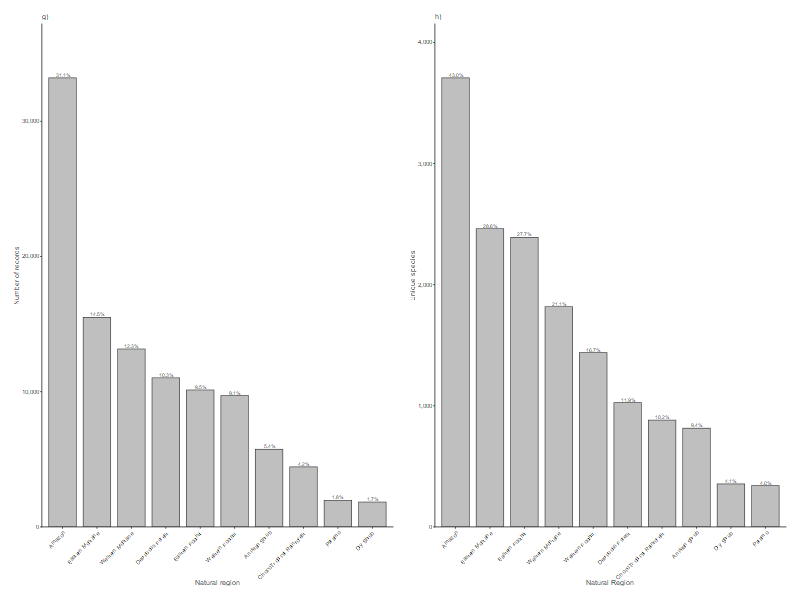

In [11]:


# -----------------------------------------------------------
# ============================================================
# 1) REGISTROS por tipo de vegetación
#    pct_records = % del total de registros del dataset
# ============================================================
veg_rec <- pts_join_reg |>
  count(veget, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(veget = factor(veget, levels = veget))

# ============================================================
# 2) ESPECIES por tipo de vegetación
#    Barra: n_species = especies únicas dentro de cada veget
#    Porcentaje: % de la riqueza global (S_global)
# ============================================================
S_global <- pts_join_reg |>
  distinct(scientificName) |>
  nrow()

veg_sp <- pts_join_reg |>
  distinct(veget, scientificName) |>
  count(veget, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species)) |>
  mutate(veget = factor(veget, levels = veget))


# ------------------------------------------------------------
# a) Registros por vegetación
# ------------------------------------------------------------
reg_natural_region <- ggplot(veg_rec, aes(x = veget, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "g)",
    x = "Natural region",
    y = "Number of records"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

# ------------------------------------------------------------
# b) Especies únicas por vegetación
# ------------------------------------------------------------
sp_natural_region <- ggplot(veg_sp, aes(x = veget, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "h)",
    x = "Natural Region",
    y = "Unique species"
  ) +
  base_theme +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

(reg_natural_region | sp_natural_region) + plot_layout(widths = c(1, 1))


## Distribution per SNAP

Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


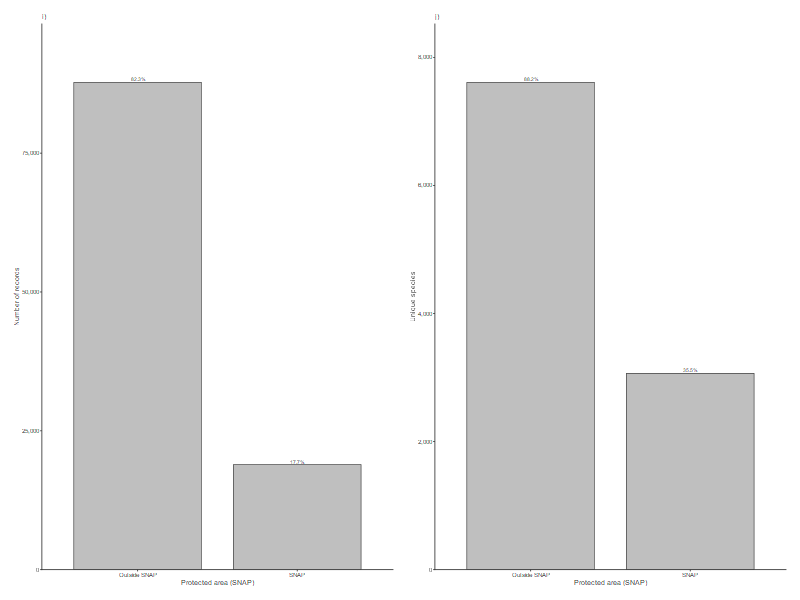

In [13]:
# =========================
# 6) Extraer info SNAP: dentro / fuera
# =========================
snap_ecu <- st_intersection(snap, ecu_u) %>% st_make_valid()
in_snap <- lengths(st_within(insects_pts_ecu, snap_ecu)) > 0
insects_pts_ecu$snap_in_out <- ifelse(in_snap, "SNAP", "Outside SNAP")


# ============================================================
# 1) REGISTROS por condición SNAP
#    pct_records = % del total de registros del dataset
# ============================================================
snap_rec <- insects_pts_ecu |>
  count(snap_in_out, name = "n_records") |>
  mutate(pct_records = 100 * n_records / sum(n_records)) |>
  arrange(desc(n_records)) |>
  mutate(snap_in_out = factor(snap_in_out, levels = snap_in_out))

# ============================================================
# 2) ESPECIES por condición SNAP
#    Barra: n_species = especies únicas dentro de cada grupo
#    Porcentaje: % de la riqueza global (S_global)
# ============================================================
S_global <- insects_pts_ecu |>
  distinct(scientificName) |>
  nrow()

snap_sp <- insects_pts_ecu |>
  distinct(snap_in_out, scientificName) |>
  count(snap_in_out, name = "n_species") |>
  mutate(pct_species = 100 * n_species / S_global) |>
  arrange(desc(n_species)) |>
  mutate(snap_in_out = factor(snap_in_out, levels = snap_in_out))


# ------------------------------------------------------------
# a) Registros dentro / fuera de SNAP
# ------------------------------------------------------------
reg_snap <- ggplot(snap_rec, aes(x = snap_in_out, y = n_records)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_records)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "i)",
    x = "Protected area (SNAP)",
    y = "Number of records"
  ) +
  base_theme

# ------------------------------------------------------------
# b) Especies únicas dentro / fuera de SNAP
# ------------------------------------------------------------
sp_snap <- ggplot(snap_sp, aes(x = snap_in_out, y = n_species)) +
  geom_col(fill = "grey75", color = "grey20", linewidth = 0.3, width = 0.8) +
  geom_text(aes(label = sprintf("%.1f%%", pct_species)),
            vjust = -0.25, size = 1.8, color = "grey20") +
  scale_y_continuous(
    labels = label_comma(accuracy = 1),
    expand = expansion(mult = c(0, 0.12))
  ) +
  labs(
    title = "j)",
    x = "Protected area (SNAP)",
    y = "Unique species"
  ) +
  base_theme

(reg_snap | sp_snap) + plot_layout(widths = c(1, 1))


## Export plot

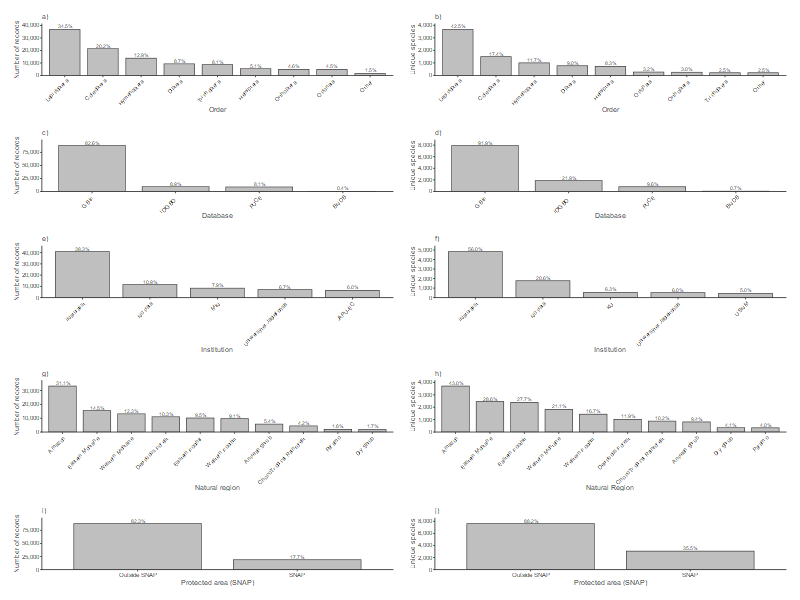

In [14]:
plots <- list(reg_order, sp_order,
  reg_database, sp_database,
  reg_institution, sp_institution,
  reg_natural_region, sp_natural_region,
  reg_snap, sp_snap)

warp_plots = wrap_plots(plots, ncol = 2) 
warp_plots

In [15]:
ggsave(
  filename = "Results/Reports/Plots/records_distribution.png",
  plot     = warp_plots,
  width    = 180, height = 200, units = "mm",
  dpi      = 600, bg = "white"
)
